In [91]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter7=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 353
Receiving objects: 100% (526/526), 28.62 MiB | 10.91 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks/notebooks


In [2]:
!pip install torch
!pip install transformers
!pip install matplotlib
!pip install datasets

In [3]:
#hide
from utils import *
setup_chapter()

Using transformers v4.36.2
Using datasets v2.16.1


In [4]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [5]:
#hide
# Suppress Haystack logging
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# Question Answering

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

## Building a Review-Based QA System

### The Dataset

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

In [6]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [7]:
#hide_output
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [8]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [9]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [10]:
#hide_output
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [11]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

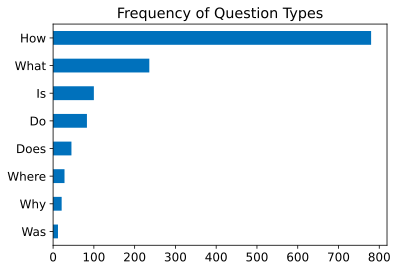

In [12]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [13]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### Sidebar: The Stanford Question Answering Dataset

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

### End sidebar

### Extracting Answers from Text

#### Span classification

<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/>

#### Tokenizing text for QA

In [14]:
#hide_output
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [16]:
#hide_input
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [17]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [18]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [19]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [20]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


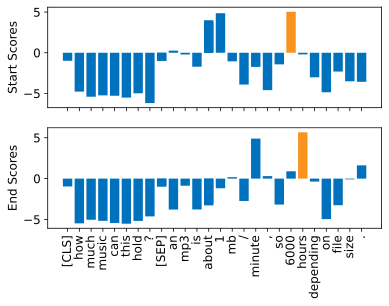

In [21]:
#hide_input
#id qa-scores
#caption Predicted logits for the start and end tokens; the token with the highest score is colored in orange

# The idea for this visualisation comes from https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [22]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [23]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651609182357788, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082965075969696,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253587365150452,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [24]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

#### Dealing with long passages

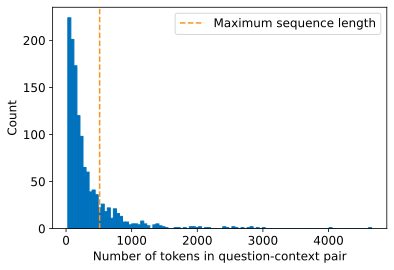

In [25]:
#hide_input
#id subjqa-dist
#caption Distribution of tokens for each question-context pair in the SubjQA training set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

In [26]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

In [27]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [28]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and do not feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears
even after listening to music with them on all day. the sound is night and day
better than any ear - bud could be and are almost as good as the pro 4aa. they
are " open air " headphones so you cannot match the bass to the sealed types,
but it comes close. for $ 32, you cannot go wrong. [SEP]



### Using Haystack to Build a QA Pipeline

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

#### Initializing a document store

In [29]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [30]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [31]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "2266a1885d70",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "k9Y9sHqPREe9UIor9h3cGQ",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [90]:
# #hide
# # Alternative if Docker is installed
# from haystack.utils import launch_es

# launch_es()

In [ ]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "96938eee37cd",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "ABGDdvbbRWmMb9Umz79HbA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


**Instantiate a Document Store**

In [32]:
!pip install farm-haystack

In [33]:
!pip install farm-haystack[elasticsearch]

In [34]:
# from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [35]:
#hide
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

https://stackoverflow.com/questions/69909352/typeerror-init-missing-1-required-positional-argument-content
the document.store.write_documents(data_json) that throws the exception. As the format for the argument has been changed from { 'text': str, 'meta': obj} to {'content': str, 'meta': obj}.

In [36]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"content": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],
                     "split": split}}
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


#### Initializing a retriever

BM25 is an improved version of the classic Term Frequency-Inverse Document Frequency (TF-IDF) algorithm and represents the question and context as sparse vectors that can be searched efficiently on Elasticsearch. The BM25 score measures how much matched text is about a search query and improves on TF-IDF by saturating TF values quickly and normalizing the document length so that short documents are favored over long ones.

In [37]:
!pip install farm-haystack[colab,ocr,preprocessing,file-conversion,pdf]

In [38]:
import haystack; dir(haystack)

['Answer',
 'BaseComponent',
 'Document',
 'EvaluationResult',
 'Label',
 'MultiLabel',
 'Pipeline',
 'Span',
 'TableCell',
 '__annotations__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'document_stores',
 'environment',
 'errors',
 'hash128',
 'haystack',
 'lazy_imports',
 'metadata',
 'mmh3',
 'modeling',
 'nodes',
 'pipelines',
 'schema',
 'set_pytorch_secure_model_loading',
 'silenceable_tqdm',
 'telemetry',
 'utils']

https://docs.haystack.deepset.ai/docs/migration

---
BM25=Best Match 25



In [39]:
# from haystack.retriever.sparse import ElasticsearchRetriever
from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(document_store=document_store)

In [40]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [41]:
print(retrieved_docs[0])

<Document: id=252e83e25d52df7311d597dc89eef9f6, content='This is a gift to
myself.  I have been a kindle user for 4 years and this is my third one.  I
never ...'>


#### Initializing a reader

https://docs.haystack.deepset.ai/docs/migration

In [42]:
!pip install farm-haystack[inference]

In [43]:
#hide_output
# from haystack.reader.farm import FARMReader
from haystack.nodes import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

In [44]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648088693618774,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293056964874268, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids':
['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


#### Putting it all together

In [45]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [46]:
n_answers = 3
# preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
#                  filters={"item_id": [item_id], "split":["train"]})
preds = pipe.run(query=query,
                 params={"Retriever": {"top_k": 3}, "Reader": {"top_k": 3},
                         "filters": {"item_id": [item_id], "split":["train"]}})#,)
                        #  filters={"item_id": [item_id], "split":["train"]})

print(f"Question: {preds['query']} \n")
# print(preds)
from haystack.utils import print_answers
print_answers(preds, details="all", max_text_len=100)
ans = [x.to_dict() for x in preds["answers"]]

for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]}")
    print(f"Answer {idx+1}: {ans[idx]['answer']}")
    print(f"Review snippet: ...{ans[idx]['context']}...")
    print("\n\n")

Question: Is it good for reading?

'Query: Is it good for reading?'
'Answers:'
[   <Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5443066358566284, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is availa...', 'offsets_in_document': [{'start': 216, 'end': 272}], 'offsets_in_context': [{'start': 47, 'end': 103}], 'document_ids': ['41f4a1710c6f3be65c7814326b662ab6'], 'meta': {'item_id': 'B0074BW614', 'question_id': '998d564607f10bf6dbbd20b33b8fbbf1', 'split': 'train'}}>,
    <Answer {'answer': 'I mainly use it for book reading', 'type': 'extractive', 'score': 0.4695245623588562, 'context': ' is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I deci...', 'offsets_in_document': [{'start': 132, 'end': 164}], 'offsets_in_context': [{'start': 59, 'end': 91}], 'document_ids': ['252e83e25d52df7311d597dc89eef9f6'], 'meta': {'item_id': 

## Improving Our QA Pipeline

### Evaluating the Retriever

In [65]:
# from haystack.pipelines import Pipeline
# from haystack.eval import EvalDocuments

# class EvalRetrieverPipeline:
#     def __init__(self, retriever):
#         self.retriever = retriever
#         self.eval_retriever = EvalDocuments()
#         pipe = Pipeline()
#         pipe.add_node(component=self.retriever, name="ESRetriever",
#                       inputs=["Query"])
#         pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
#                       inputs=["ESRetriever"])
#         self.pipeline = pipe


# pipe = EvalRetrieverPipeline(es_retriever)

`EvalDocuments` and `EvalAnswer` nodes are deprecated since December 2021 and we recommend to use Pipeline.eval instead since then.
https://github.com/deepset-ai/haystack/issues/4192

In [47]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=es_retriever)

In [48]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
    # Populate labels for questions without answers
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
    labels.append(label)

In [49]:
print(labels[0])

<Label: {'id': '1d792375-3bf9-4437-93fe-df0797ea3619', 'query': 'What is the
tonal balance of these headphones?', 'document': {'id':
'f011c75fb8d26066217e64b3ff470d84', 'content': "I have been a headphone fanatic
for thirty years and have owned and used a variety of headphones over those
years, to include Stax SR-5, Sennheiser HD-424 and HD-580.  The Sony MDRV6
excells as the best value of any headphone that I've ever owned.  They are
especially good at producing natural-sounding deep bass, and the overall
octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the 

In [50]:
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 358 question-answer pairs


In [51]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [52]:
print(labels_agg[109])

<MultiLabel: {'labels': [{'id': '95f441de-f7f7-46cc-9c83-863eaf337712', 'query':
'How does the fan work?', 'document': {'id': 'a5db4d52bb4d0fcadff2b8a6f4e54d75',
'content': 'the usb on the back caused my mac to restart when i would plug
something into about 50% of the time.  very annoying but the fan is really
really good!', 'content_type': 'text', 'meta': {}, 'id_hash_keys': ['content'],
'score': None, 'embedding': None}, 'is_correct_answer': True,
'is_correct_document': True, 'origin': 'gold-label', 'answer': {'answer': 'the
fan is really really good', 'type': 'extractive', 'score': None, 'context':
None, 'offsets_in_document': None, 'offsets_in_context': None, 'document_ids':
None, 'meta': {}}, 'pipeline_id': None, 'created_at': '2024-01-29 02:02:27',
'updated_at': '2024-01-29 02:02:27', 'meta': {'item_id': 'B002MU1ZRS',
'question_id': '5a9b7616541f700f103d21f8ad41bc4b'}, 'filters': {'item_id':
['B002MU1ZRS'], 'split': ['test']}}, {'id':
'0976c8f8-8c6f-48bd-ad18-76b31bda758b', 'quer

In [53]:
!pip install farm-haystack[metrics]

In [54]:
!pip install rapidfuzz

In [55]:
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [56]:
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.95


In [57]:
#hide_output
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    # Calculate the maximum top_k
    max_top_k = max(topk_values)

    # Create a pipeline
    p = DocumentSearchPipeline(retriever=retriever)

    # Run inference at most top_k by traversing question-answer pairs in the test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate recall for each top_k value
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")

es_topk_df = evaluate_retriever(es_retriever)

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

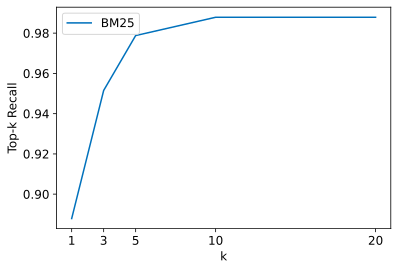

In [58]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([es_topk_df], ["BM25"])

#### Dense Passage Retrieval

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

In [60]:
#hide_output
# from haystack.retriever.dense import DensePassageRetriever
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [61]:
#hide_output
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings: 100%|██████████| 1616/1616 [00:25<00:00, 65.67 Docs/s]
Updating embeddings: 10000 Docs [00:41, 240.04 Docs/s]


/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1464: SettingWithCopyWarning: 
A value is trying to be set on a c

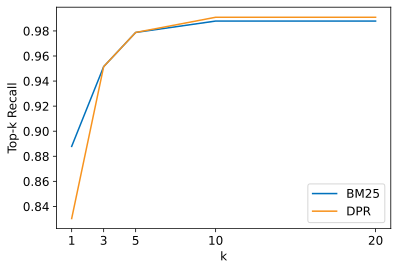

In [62]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

Concluded DPR is better than BM25

### Evaluating the Reader

In [63]:
# from farm.evaluation.squad_evaluation import compute_f1, compute_exact
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [64]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [74]:
#hide_output
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

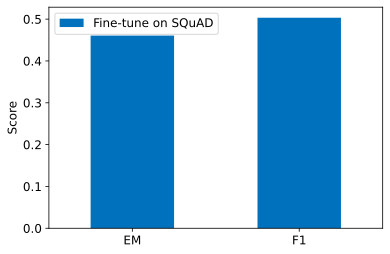

In [75]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### Domain Adaptation

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

In [76]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [77]:
#hide_output
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [78]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)

convert_to_squad(dfs)

In [79]:
#hide_output
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"
# GPU utilization till: 6.4GBs
reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

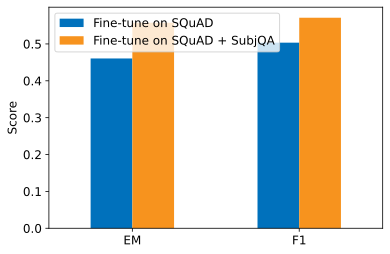

In [80]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [81]:
#hide_output
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [82]:
#hide_output
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the 

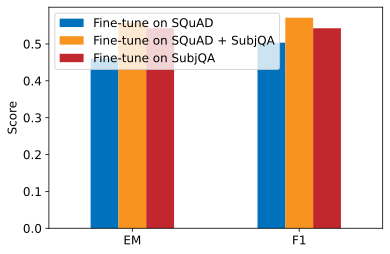

In [83]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### Evaluating the Whole QA Pipeline

In [84]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=es_retriever, reader=reader)

# Evaluate
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract Reader metrics
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

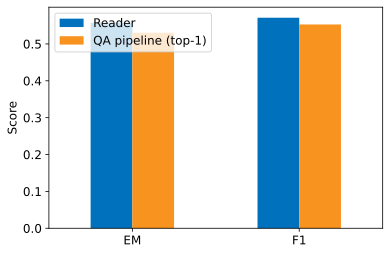

In [85]:
#hide_input
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

END